# Space Fund Realty (SFR) Analysis

The objective of this project is to analyze SpaceFund Realty (SFR) ratings for aerospace companies and their missions in order to support informed investment decisions. SFR is a scoring framework that evaluates companies based on factors such as mission performance, payload capacity, launch cost, and other operational metrics.

The SFR rating ranges from 1 to 9, where higher scores indicate more technologically mature, stable, and well-developed companies. By examining these ratings alongside mission and cost data, this analysis aims to identify trends, compare company performance, and highlight investment-relevant insights across the aerospace sector.

## Data Dictionary

- **Company** – Name of the company  
- **SFR** – SpaceFund Realty rating of the company  
- **Payload (kg)** – Payload capacity of the mission (in kilograms)  
- **Launch Cost (million USD)** – Launch cost of the mission in million USD  
- **Price per kg** – Cost per kilogram of payload  
- **Launch Class** – Launch class/category of the mission  
- **Orbit Altitude** – Orbit altitude of the mission  
- **Tech Type** – Technology type used in the mission  
- **Country** – Country where the company is based  
- **HQ Location** – Headquarters location of the company  
- **Description** – Description of the mission  


In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Loading the dataset
df = pd.read_csv('/content/Launch SFR.csv')
df.head()

,Company,SFR,Payload (kg),Launch Cost ($M),Price ($/kg),Funding ($M),Launch Class,Orbit Altitude,Tech Type,Country,HQ Location,Description
0,Arianespace/Avio,9,"20,000",170.00,"8,500",Public,"Medium, Heavy",LEO,Rocket,Italy,Colleferro,Developing the Vega & Ariane launch vehicles
1,Astra Space,9,300,3.95,"13,167",Public,Small,LEO,Rocket,United States,"Alameda, CA",Providing routine launch access to Earth orbit...
2,Black Sky Aerospace,9,350,0.60,"1,714",-,Small,Suborbital,Rocket,Australia,"Browns Plains, Queensland","Offers a range of sounding rockets, capable of..."
3,Blue Origin,9,0,0.00,0,-,"Tourism, Small, Heavy",Suborbital,Rocket,United States,"Kent, WA",Lowering the cost of access to space with reus...
4,CNIM Air Space,9,"2,700",0.00,0,Public,"Small, Medium",Suborbital,Balloon,France,Ayguesvives,Balloons that lift anything from a few kilogra...


## Data Preprocessing

In [3]:
# Checking the shape of the dataset
df.shape

(183, 12)

In [4]:
# Checking the datatypes of the columns
df.dtypes

,0
Company,object
SFR,int64
Payload (kg),object
Launch Cost ($M),float64
Price ($/kg),object
Funding ($M),object
Launch Class,object
Orbit Altitude,object
Tech Type,object
Country,object


In [5]:
# type casting
df['Payload (kg)'] = df['Payload (kg)'].astype(str).str.replace(',', '').astype(float)
df['Launch Cost ($M)'] = df['Launch Cost ($M)'].astype(str).str.replace(',', '').astype(float)
df['Price ($/kg)'] = df['Price ($/kg)'].astype(str).str.replace(',', '').astype(float)

In [6]:
# Checking '-' (null values) values in the dataset
df.isin(['-']).sum()

,0
Company,0
SFR,0
Payload (kg),0
Launch Cost ($M),0
Price ($/kg),0
Funding ($M),110
Launch Class,16
Orbit Altitude,3
Tech Type,0
Country,0


Most values in the Funding ($M) column are missing; therefore, the column is removed from the dataset. Missing values in Launch Class and Orbit Altitude are replaced using the mode of their respective columns.

In [7]:
# dropping the column
df.drop(['Funding ($M)'], axis=1, inplace=True, errors='ignore')

# replacing the '-' values with mode
df['Launch Class'] = df['Launch Class'].replace('-', df['Launch Class'].mode()[0])
df['Orbit Altitude'] = df['Orbit Altitude'].replace('-', df['Orbit Altitude'].mode()[0])

Dropping HQ location column because the country of origin is already there.

In [8]:
df.drop(['HQ Location'], axis=1, inplace=True)

In [9]:
# Checking for unique values in the dataset
df.nunique()

,0
Company,183
SFR,10
Payload (kg),65
Launch Cost ($M),46
Price ($/kg),53
Launch Class,10
Orbit Altitude,4
Tech Type,8
Country,31
Description,183


In [10]:
cols = ['Launch Class', 'Orbit Altitude', 'Tech Type']
for i in cols:
    print(i, df[i].unique(), '\n')

Launch Class ['Medium, Heavy' 'Small' 'Tourism, Small, Heavy' 'Small, Medium'
 'Heavy, Super Heavy' 'Tourism' 'Medium' 'Small, Heavy' 'Tourism, Medium'
 'Heavy'] 

Orbit Altitude ['LEO' 'Suborbital' 'GTO' 'Lunar'] 

Tech Type ['Rocket' 'Balloon' 'Balloon, Rocket' 'Spaceplane' 'Plane, Rocket' 'Other'
 'Rocket, Other' 'Rocket, Spaceplane'] 



In [11]:
def l_class(launch):
    if launch in ['Medium, Heavy','Medium']:
        return 'Medium'
    elif launch in ['Small', 'Small, Medium', 'Small, Heavy']:
        return 'Small'
    elif launch in ['Heavy', 'Heavy, Super Heavy']:
        return 'Heavy'
    elif launch in ['Tourism', 'Tourism, Small, Heavy','Tourism, Medium']:
        return 'Tourism'
df['Launch Class'] = df['Launch Class'].apply(l_class)

In [12]:
df['Launch Class'].value_counts()

,count
Launch Class,
Small,152
Medium,15
Tourism,10
Heavy,6


In [13]:
def tech_type(tech):
    if tech in ['Rocket', 'Plane, Rocket', 'Rocket, Other', 'Rocket, Spaceplane']:
        return 'Rocket'
    elif tech in ['Ballon', 'Balloon, Rocket']:
        return 'Balloon'
    elif tech in ['Spaceplane']:
        return 'Spaceplane'
    else:
        return 'Other'
df['Tech Type'] = df['Tech Type'].apply(tech_type)

In [14]:
df['Tech Type'].value_counts()

,count
Tech Type,
Rocket,133
Other,23
Spaceplane,20
Balloon,7


## Grouping companies by description

The Description column contains mostly unique values; therefore, entries are grouped into seven broader categories based on the nature of each company’s activities. This categorization helps standardize the data and enables more meaningful analysis.

The seven categories are:

- Launch Vehicle Development

- Launch Services

- Balloon-Based Technologies

- Space Tourism and Suborbital

- Satellite Technology and Services

- Innovative Propulsion Technologies

- Space Access and Technology Innovation

In [15]:
def description(description):
    if description in [
    'Developing the Vega & Ariane launch vehicles',
    'Developing the Ceres-1 and Pallas-1 launch vehicles',
    'Developing the Firefly Alpha launch vehicle; highest payload performance with the lowest cost per kg to orbit in its vehicle class',
    'Developing suborbital rockets to provide access and research for traditional and ‘New-Space’ markets',
    'The first rocket company and launch site for cubesat payloads in New Zealand',
    'Developing the ERIS launch vehicles to provide reliable and cost-effective access to space',
    'Buildig the Xogdor rocket to test payloads at supersonic speeds and at the edge of space',
    'Building a private 3-stage nanosatellite launch vehicle in China',
    'Developing the LAROS-RC2 orbital carrier and accompanying mobile launch infrastructure',
    'Developing the Trans-Atmospheric Flight Vehicle (TAV 1)',
    'Developing suborbital and orbital launch vehicles',
    'Developing a series of Launch Vehicles based on high-altitude air launch',
    'Building a hypersonic space plane that can takeoff from anywhere in any weather',
    'Developing a unique launch vehicle and propulsion system',
    'Building a space launch system for sending hardened satellites and bulk cargo into space',
    'Developing a reactive, reliable and cost-efficient nano-launcher',
    'Developing a next generation of reusable launch vehicles for microgravity research',
    'Building a reusable three-person rocket ship for space tourism',
    'Developing Infinity, a small reusable rocket',
    'Developing high-performance, low carbon micro launch vehicles']:
        return 'Launch Vehicle Development'
    elif description in [
    'Providing routine launch access to Earth orbit for entrepreneurs and enterprises',
    'Launch vehicle manufacturer and launch services provider',
    'Commercial launch vehicle manufacturer and space launch provider in China',
    'Launch services for small, micro and nano satellites',
    'Providing launch services to LEO at an affordable cost',
    'Enabling Low cost access to space with the Aerospike engined reusable Small satellite launch vehicle "MESO"',
    'Providing passengers with a trip into the stratosphere',
    'Provides earth-to-space space delivery services for small payloads',
    'Dedicated nanosatellite launch provider',
    'Rapid response small satellite launch vehicles for government and commercial customers',
    'Provding dedicated launch services for cube and nanosatellites',
    'Integrated launch services for the Zenit Launch Vehicle via a mobile sea platform',
    'Cost-effective small satellite launch services from the United Kingdom',
    'SpaceRyde offers affordable, on-schedule, dedicated launch for small sats',
    'Enabling transportation to LEO',
    'Reusable hybrid rocketry',
    'Developing a reliable tow-glider launch system',
    'Affordable and reliable small satellite launch system for LEO, SSO, and GEO missions',
    'Customized launch services for sub-orbital and orbital payloads',
    'SpaceBox is a suborbital launch and recovery platform designed to enable affordable access to space for educational, professional, consumer and hobbyist payloads']:
        return 'Launch Services'
    elif description in [
    'Offers a range of sounding rockets, capable of flights up to 300km in multistage configurations',
    'Balloons that lift anything from a few kilograms to several tons and are able to operate at an altitude as low as a few hundred meters or as high as 40 km',
    'Launching stratospheric balloons for research and promotional purposes',
    'Balloon-based small satellite launcher',
    'Building a ballooning platform to offer novel access to the mesosphere']:
        return 'Balloon-Based Technologies'
    elif description in [
    'Building rockets to launch small satellites',
    'Developing a zero-emission space tourism platform',
    'Personalized engineering support and dedicated airborne orbital launch platform',
    'Revolutionizing near space tourism and opening it to a greater audience']:
        return 'Space Tourism Suborbital'
    elif description in [
    'Designs, manufactures, and operates launch vehicles, propulsion systems, and satellites and related components',
    'Developing Dream Chaser, a multi-mission space utility vehicle designed to transport crew and cargo to low-Earth orbit',
    'A rocket, satellite, and spacecraft manufacturing company.',
    'Mass production of on-demand launchers for small sats',
    'Designing a single stage to orbit hypersonic vehicle of revolutionary design and propulsion capability',
    'Building a single-stage to orbit launch system dedicated to small payloads']:
        return 'Satellite Technology and Services'
    elif description in  [
    'Developing a unique line of rockets powered by bio-derived fuels to launch tiny satellites into space',
    'Using clean tech to develop a sustainable and cheap rocket called Haribon SLS',
    'Developing hybrid small satellite launch vehicles',
    'Privately developing rocket engines and suborbital launch vehicles in Japan',
    'Creating a reusable suborbital space complex for tourist flights into space',
    'Using RAM-accelerators to change the economics of space launch',
    'Developing a range of sustainable, reusable launchers dedicated to the launch of small satellites',
    'Developing electromagnetic launch systems to change how we launch payloads into space',
    'Redesigning launch from the ground up',
    'Developing SOL ASPIRET, a suborbital spaceplane',
    'Developing PROTEUS, an innovative hybrid and autonomous launcher for small sats']:
        return 'Innovative Propulsion Technologies'
    else:
        return 'Space Access and Technology Innovation'
df['Description'] = df['Description'].apply(description)

In [16]:
df['Description'].value_counts()

,count
Description,
Space Access and Technology Innovation,123
Launch Vehicle Development,19
Launch Services,18
Innovative Propulsion Technologies,10
Satellite Technology and Services,6
Space Tourism Suborbital,4
Balloon-Based Technologies,3


In [17]:
df.describe()

,SFR,Payload (kg),Launch Cost ($M),Price ($/kg)
count,183.000000,183.000000,183.000000,183.000000
mean,3.726776,2579.677596,4.840956,6587.256831
std,2.527148,8834.385310,19.132872,12755.241486
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,16.000000,0.000000,0.000000
50%,3.000000,186.000000,0.000000,0.000000
75%,5.000000,746.500000,1.500000,9250.000000
max,9.000000,63800.000000,170.000000,100000.000000


The descriptive statistics indicate that the minimum values for Payload (kg), SFR, and Price (kg) and Landcost (M) are 0, which is not realistic. These zero values are treated as missing data and are replaced with the mean or median of their respective columns.

### Feature Adjustment

The **Price (per kg)** column is removed due to its high correlation with **Launch Cost (M)**.

Launch Cost (M) is calculated as:

$$
\text{Launch Cost (M)} = \text{Price (per kg)} \times \text{Payload (kg)} / 1000
$$


In [18]:
df.drop(columns = 'Price ($/kg)', axis=1, inplace=True)

In [19]:
df.head()

,Company,SFR,Payload (kg),Launch Cost ($M),Launch Class,Orbit Altitude,Tech Type,Country,Description
0,Arianespace/Avio,9,20000.0,170.00,Medium,LEO,Rocket,Italy,Launch Vehicle Development
1,Astra Space,9,300.0,3.95,Small,LEO,Rocket,United States,Launch Services
2,Black Sky Aerospace,9,350.0,0.60,Small,Suborbital,Rocket,Australia,Balloon-Based Technologies
3,Blue Origin,9,0.0,0.00,Tourism,Suborbital,Rocket,United States,Space Access and Technology Innovation
4,CNIM Air Space,9,2700.0,0.00,Small,Suborbital,Other,France,Space Access and Technology Innovation


## Exploratory Data Analysis (EDA)

The exploratory data analysis focuses on understanding the distribution of the dataset. This includes examining the patterns, trends, and characteristics of individual variables. Subsequently, the relationships between the dependent variable and independent variables are analyzed to identify potential correlations and insights.

### Country of Origin

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, 'United States'),
  Text(1, 0, 'United Kingdom'),
  Text(2, 0, 'China'),
  Text(3, 0, 'India'),
  Text(4, 0, 'France'),
  Text(5, 0, 'Japan'),
  Text(6, 0, 'Australia'),
  Text(7, 0, 'Canada'),
  Text(8, 0, 'Spain'),
  Text(9, 0, 'Russia'),
  Text(10, 0, 'Germany'),
  Text(11, 0, 'South Korea'),
  Text(12, 0, 'Argentina'),
  Text(13, 0, 'Netherlands'),
  Text(14, 0, 'Ukraine'),
  Text(15, 0, 'South Africa'),
  Text(16, 0, 'Brazil'),
  Text(17, 0, 'Italy'),
  Text(18, 0, 'Sweden'),
  Text(19, 0, 'Poland'),
  Text(20, 0, 'Philippines'),
  Text(21, 0, 'Taiwan'),
  Text(22, 0, 'Norway'),
  Text(23, 0, 'Malaysia'),
  Text(24, 0, 'Thailand'),
  Text(25, 0, 'Croatia'),
  Text(26, 0, 'Turkey'),
  Text(27, 0, 'Uzbekistan'),
  Text(28, 0, 'Czech Republic'),
  Text(29, 0, 'Luxembourg'),
  Text(30, 0, 'Pakistan

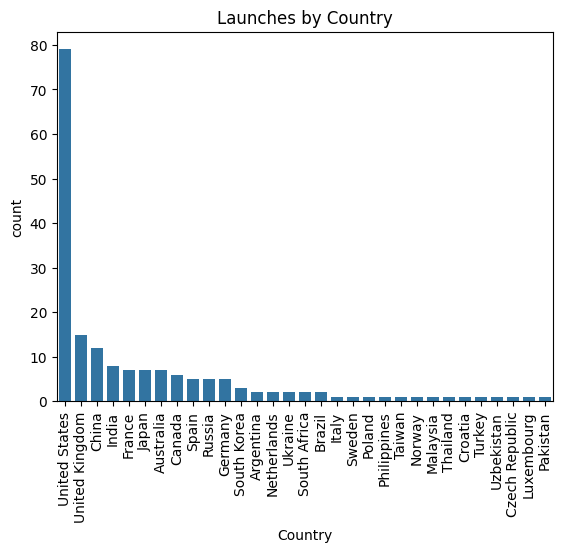

In [20]:
sns.countplot(x='Country', data=df, order=df['Country'].value_counts().index).set_title('Launches by Country')
plt.xticks(rotation=90)

This graph displays the number of launches per country. The United States leads with nearly 80 missions, followed by the United Kingdom with 15 missions, China with 13 missions, and India with 9 missions. Overall, the top five countries are the US, UK, China, India, and a group of countries with equal numbers of missions, including Australia, France, and Japan.

### Tech Type

Text(0.5, 1.0, 'Launches by Tech Type')

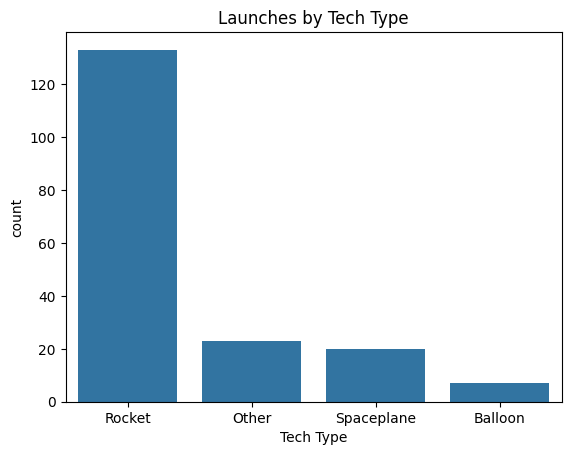

In [21]:
sns.countplot(x = 'Tech Type', data = df, order = df['Tech Type'].value_counts().index).set_title('Launches by Tech Type')

Most missions in the dataset fall under rocket-based operations, followed by miscellaneous, spaceplane, and balloon missions. This distribution highlights varying levels of mission complexity across companies. The dominance of rocket missions indicates that many organizations possess the technical capacity to develop propulsion systems and perform orbital launches. Spaceplane missions reflect efforts toward reusable vehicles and may signal activity in emerging areas such as space tourism. Balloon missions, on the other hand, represent balloon-based platforms used to transport payloads to near-space environments for data collection and research purposes.

### Launch Class

Text(0.5, 1.0, 'Launches by Launch Class')

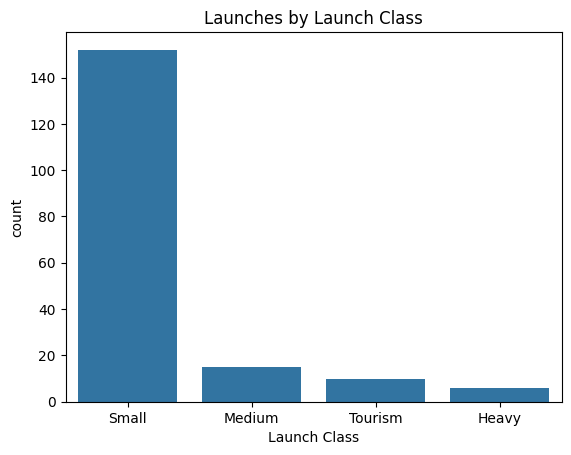

In [22]:
sns.countplot(x = 'Launch Class', data = df, order = df['Launch Class'].value_counts().index).set_title('Launches by Launch Class')

Most missions fall under the Small launch class, indicating that many companies are focused on developing small launch vehicles, which suggests early-stage rocket development. The second most common category is Medium, showing that some companies are building medium-class launch vehicles capable of carrying larger payloads. The Tourism category represents organizations engaged in space tourism and suborbital missions. Finally, the Heavy launch class includes companies developing heavy-lift vehicles designed to transport substantial payloads into space.

### Orbit Altitude

Text(0.5, 1.0, 'Launches by Orbit Altitude')

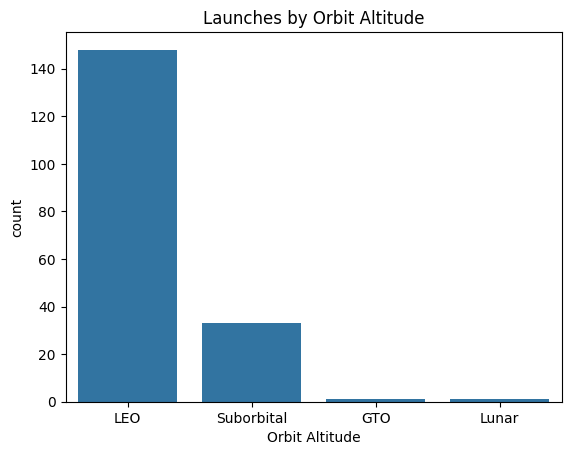

In [23]:
sns.countplot(x = 'Orbit Altitude', data = df, order = df['Orbit Altitude'].value_counts().index).set_title('Launches by Orbit Altitude')

This graph illustrates the distribution of mission orbit altitudes and aligns with earlier observations on mission technology types and launch classes. Over 140 missions target Low Earth Orbit (LEO), indicating that most companies focus on small launch vehicles designed to deliver lighter payloads to LEO. The second most common category is Suborbital, reflecting participation in space tourism and suborbital flight activities. Geostationary Transfer Orbit (GTO) follows, representing missions capable of transporting heavier payloads to higher orbits. The final category is Lunar, which includes companies developing capabilities for missions carrying substantial payloads to the Moon.

### Company Description

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Space Access and Technology Innovation'),
  Text(1, 0, 'Launch Vehicle Development'),
  Text(2, 0, 'Launch Services'),
  Text(3, 0, 'Innovative Propulsion Technologies'),
  Text(4, 0, 'Satellite Technology and Services'),
  Text(5, 0, 'Space Tourism Suborbital'),
  Text(6, 0, 'Balloon-Based Technologies')])

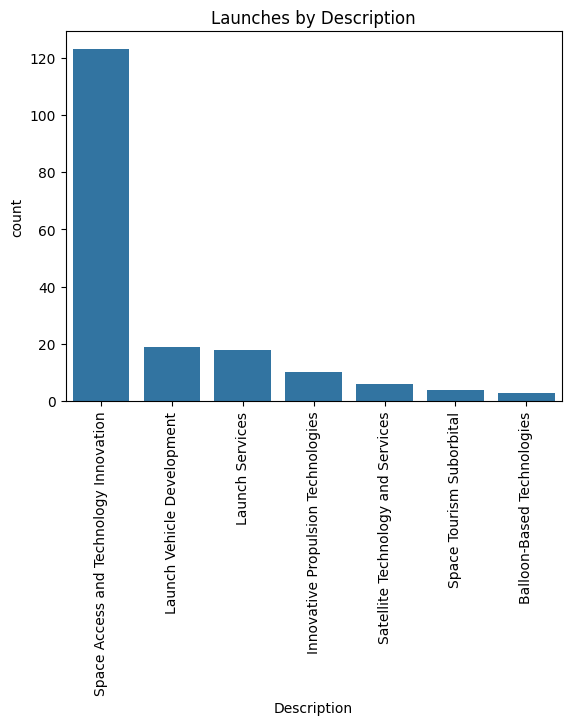

In [24]:
sns.countplot(x = 'Description', data = df, order = df['Description'].value_counts().index).set_title('Launches by Description')
plt.xticks(rotation=90)

These graphs provide an overview of company focus areas based on their descriptions. Most companies operate in Space Access and Technology Innovation, followed by Launch Services and Launch Vehicle Development. A smaller number of organizations are engaged in Innovative Propulsion Technologies, concentrating on the development of new propulsion systems. Fewer companies are involved in Satellite Technology and Services as well as Space Tourism and Suborbital activities. The final category, Balloon-Based Technologies, includes companies working on balloon-based platforms and related technologies.

### Payload Distribution

Text(0.5, 1.0, 'Payload Distribution')

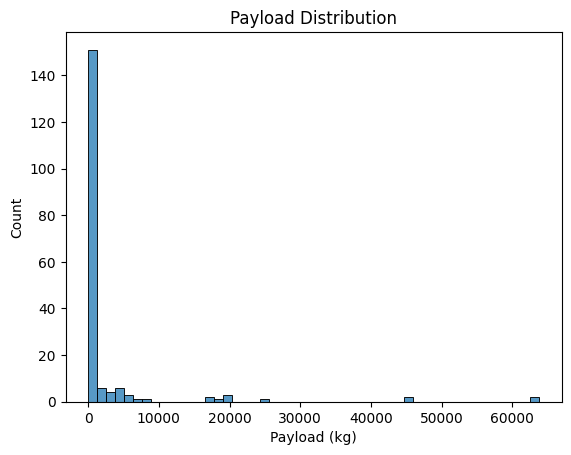

In [25]:
sns.histplot(x = 'Payload (kg)', data = df, bins = 50).set_title('Payload Distribution')

Most missions carry payloads below 1,000 kg, followed by missions with payloads ranging between 1,000 kg and 10,000 kg. A smaller number of missions have payloads approaching 20,000 kg, which likely correspond to heavy launch classes. Additionally, a few missions exceed 40,000 kg, which may represent outliers within the dataset.

### Launch Cost Distribution

Text(0.5, 1.0, 'Launch Cost Distribution')

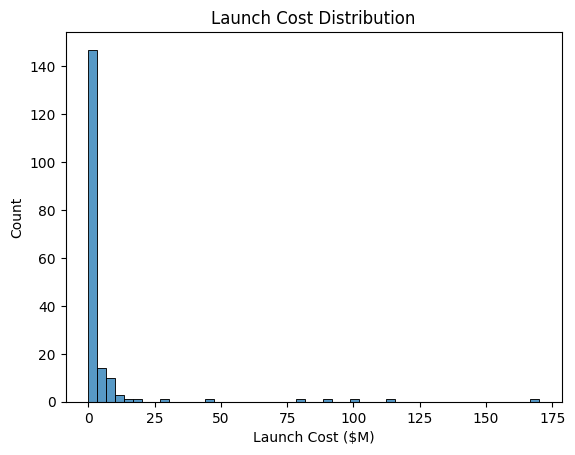

In [26]:
sns.histplot(x = 'Launch Cost ($M)', data = df, bins = 50).set_title('Launch Cost Distribution')

In the dataset, most launch costs are concentrated between 5 and 10 million USD, with only a small number of missions exceeding 100 million USD. This distribution highlights the scale of missions based on expenditure. Missions with launch costs below 5 million USD represent small-scale operations, followed by medium-scale missions with costs ranging from 5 to 10 million USD.

### SFR Distribution

Text(0.5, 1.0, 'SFR Distribution')

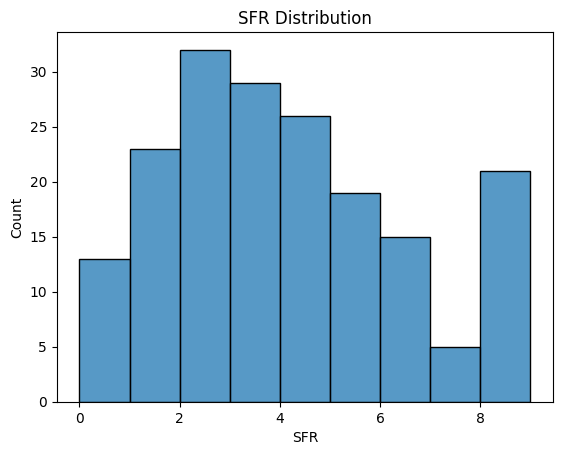

In [27]:
sns.histplot(x = 'SFR', data = df, bins = 9).set_title('SFR Distribution')

This graph illustrates the distribution of SpaceFund Realty (SFR) ratings across companies. Most companies have SFR values between 2 and 4, with rating 4 being the most common. This concentration at lower ratings indicates limited technological maturity and financial stability across much of the dataset. Lower SFR scores may constrain research and development efforts as well as future mission capabilities due to funding limitations. Overall, the distribution suggests that many companies represented in the dataset are in the early stages of development.

## Checking the relationship between and the Independent variables.

### Top 10 countries with SFR greater than 6

Text(0.5, 0, 'Number of Launches')

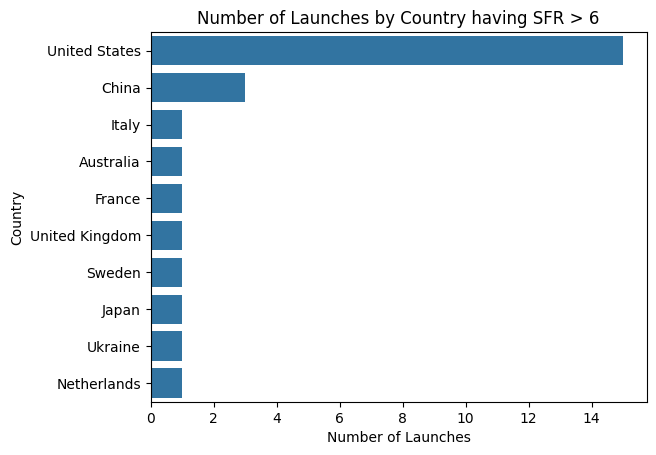

In [28]:
sns.barplot(y = 'Country', x = 'SFR', data = df[df['SFR'] > 6], estimator = len, order = df[df['SFR'] > 6]['Country'].value_counts().index).set_title('Number of Launches by Country having SFR > 6')
plt.xlabel('Number of Launches')

This visualization illustrates the relationship between SFR and country of origin, highlighting the top ten countries with SFR values greater than 6. The United States has the highest number of companies with SFR above 6, suggesting stronger company maturity and investment potential. China ranks second; although third in total mission count, it has more high-SFR companies than the United Kingdom. All remaining countries represented in the chart have only one company with an SFR greater than 6.

Beyond serving as an investment indicator, SFR also reflects organizational maturity. Lower SFR values generally correspond to companies in earlier stages of development, while higher scores indicate more established operations and technological readiness.

### SFR and Tech Type

Text(0.5, 1.0, 'SFR and Tech Type')

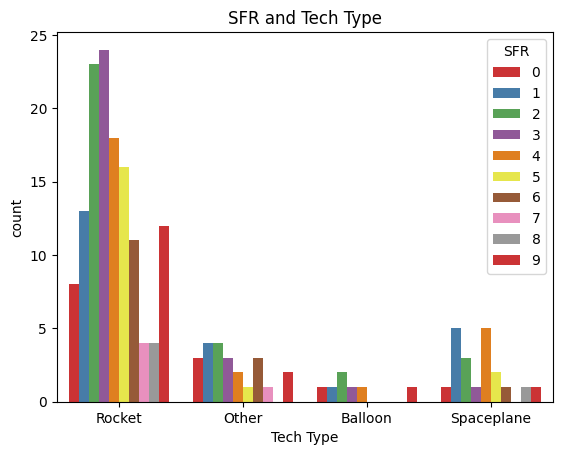

In [29]:
sns.countplot(x = 'Tech Type', data = df, hue= 'SFR', palette= 'Set1').set_title('SFR and Tech Type')

This graph presents mission technology types alongside their corresponding SFR values. Most rocket-type missions fall within SFR ratings of 2 and 3, indicating that many companies operating in this area are in early stages of development. However, this does not imply the absence of mature organizations, as approximately 12 rocket missions achieve an SFR of 9.

For spaceplane missions, SFR values are primarily concentrated at 1 and 4, suggesting a split between companies that are newly established and those with more substantial experience in the field. Only a small number of spaceplane missions reach an SFR of 9.

Balloon missions are largely associated with SFR values of 2 and 3, which similarly reflects early-stage development among companies working with balloon-based technologies.

### SFR and Launch Class

Text(0.5, 1.0, 'SFR and Launch Class')

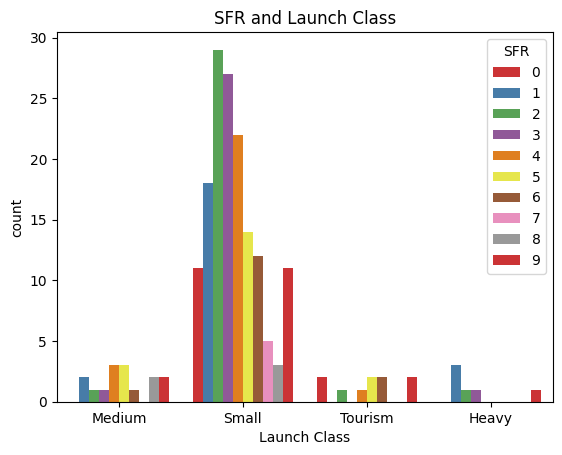

In [30]:
sns.countplot(x = 'Launch Class', data = df, hue= 'SFR', palette= 'Set1').set_title('SFR and Launch Class')

Since Launch Class is closely related to mission technology type, this graph shows patterns similar to the previous one. Small launch-class missions mostly have SFR values between 2 and 3, consistent with rocket-type missions, indicating early-stage development. Medium launch-class missions generally fall between 4 and 5 SFR, while Heavy launch-class missions exhibit the lowest SFR of 1. Tourism-class missions have SFR values between 5 and 6, suggesting that companies operating in space tourism are relatively well-established.

### SFR and Orbit Altitude

Text(0.5, 1.0, 'SFR and Orbit Altitude')

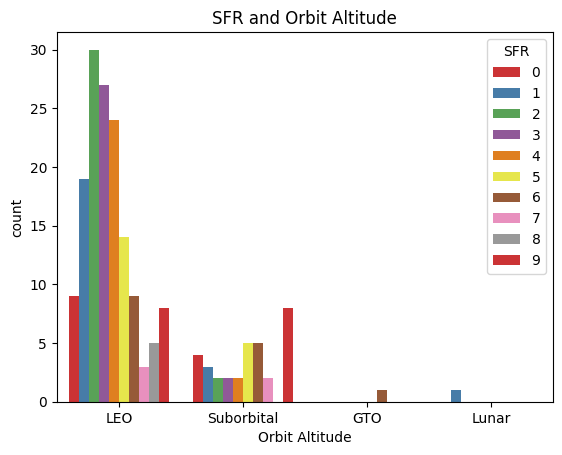

In [31]:
sns.countplot(x = 'Orbit Altitude', data = df, hue= 'SFR', palette= 'Set1').set_title('SFR and Orbit Altitude')

Some similarities are observed across the previous graphs and this one. Most missions are rocket-type with small launch class, which corresponds to LEO orbits and SFR values of 2–3. Suborbital missions exhibit the highest SFR of 9, indicating that companies operating in this segment are well-established. Only a few missions target GTO or Lunar orbits, suggesting that companies working on these missions are in early stages of development.

### SFR and Description

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Launch Vehicle Development'),
  Text(1, 0, 'Launch Services'),
  Text(2, 0, 'Balloon-Based Technologies'),
  Text(3, 0, 'Space Access and Technology Innovation'),
  Text(4, 0, 'Satellite Technology and Services'),
  Text(5, 0, 'Space Tourism Suborbital'),
  Text(6, 0, 'Innovative Propulsion Technologies')])

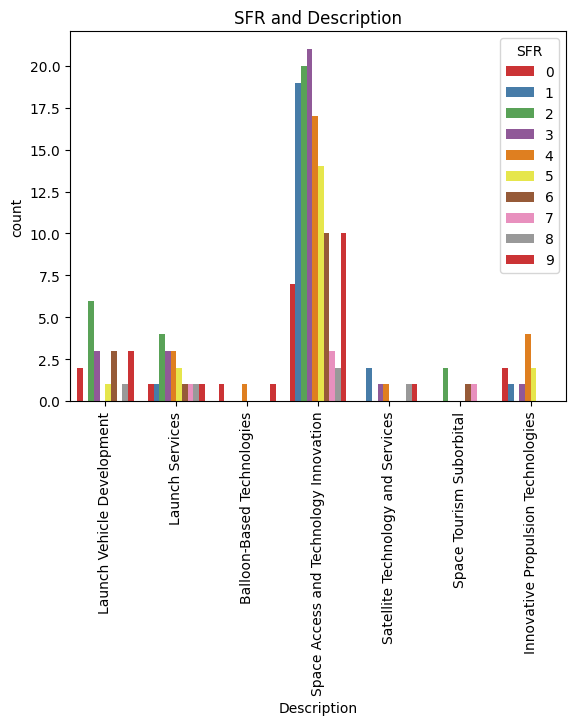

In [32]:
sns.countplot(x = 'Description', data = df, hue= 'SFR', palette= 'Set1').set_title('SFR and Description')
plt.xticks(rotation=90)

### SFR and Payload

/tmp/ipython-input-1524839893.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'SFR', y = 'Payload (kg)', data = df, ax = ax[0], palette = 'Set1').set_title('SFR and Payload')
/tmp/ipython-input-1524839893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'SFR', y = 'Payload (kg)', data = df, ax = ax[1], palette = 'Set1').set_title('SFR and Payload')


Text(0.5, 1.0, 'SFR and Payload')

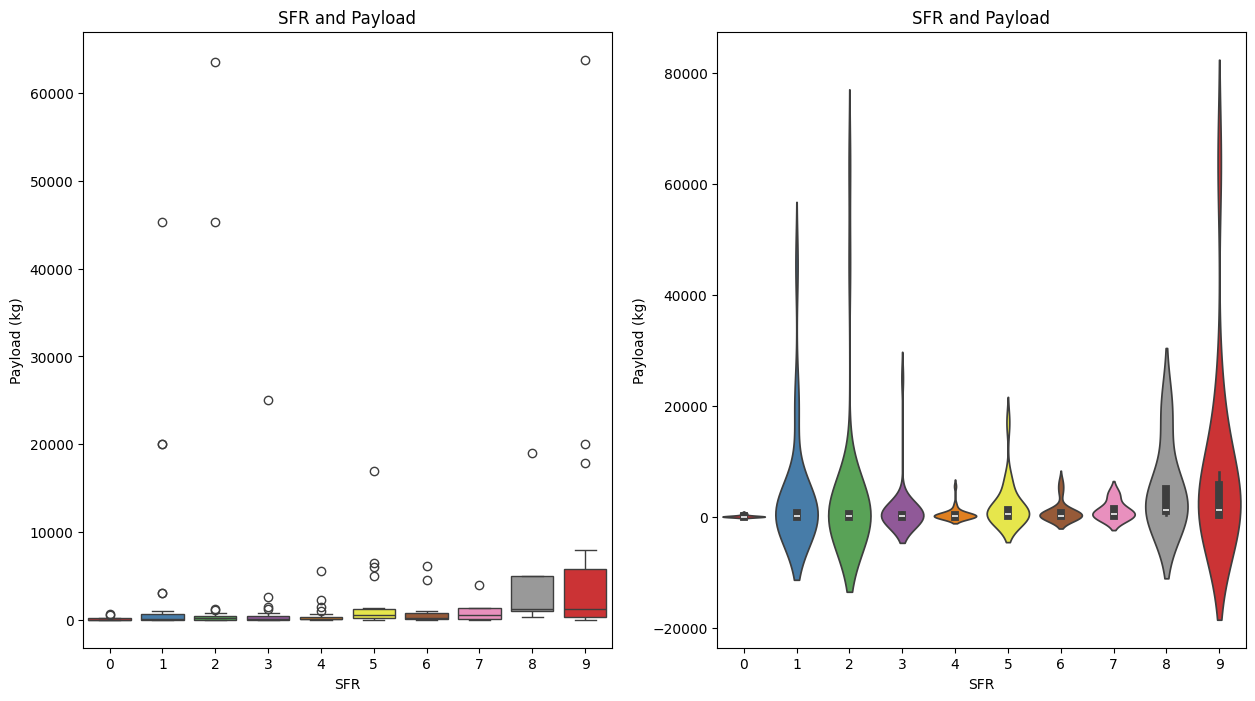

In [33]:
fig, ax = plt.subplots(1,2,figsize=(15, 8))
sns.boxplot(x = 'SFR', y = 'Payload (kg)', data = df, ax = ax[0], palette = 'Set1').set_title('SFR and Payload')
sns.violinplot(x = 'SFR', y = 'Payload (kg)', data = df, ax = ax[1], palette = 'Set1').set_title('SFR and Payload')

These graphs illustrate the relationship between mission payload mass and SFR. Both graphs show a trend of increasing SFR with larger payloads, indicating that well-established companies are capable of transporting heavier payloads into space. Companies with lower SFR are in early stages of development and lack the capability to carry large payloads.

Additionally, the boxplot highlights the presence of outliers in the dataset. These outliers will be addressed during the data preprocessing stage.

### SFR and Launch Cost

Text(0.5, 1.0, 'SFR and Launch Cost')

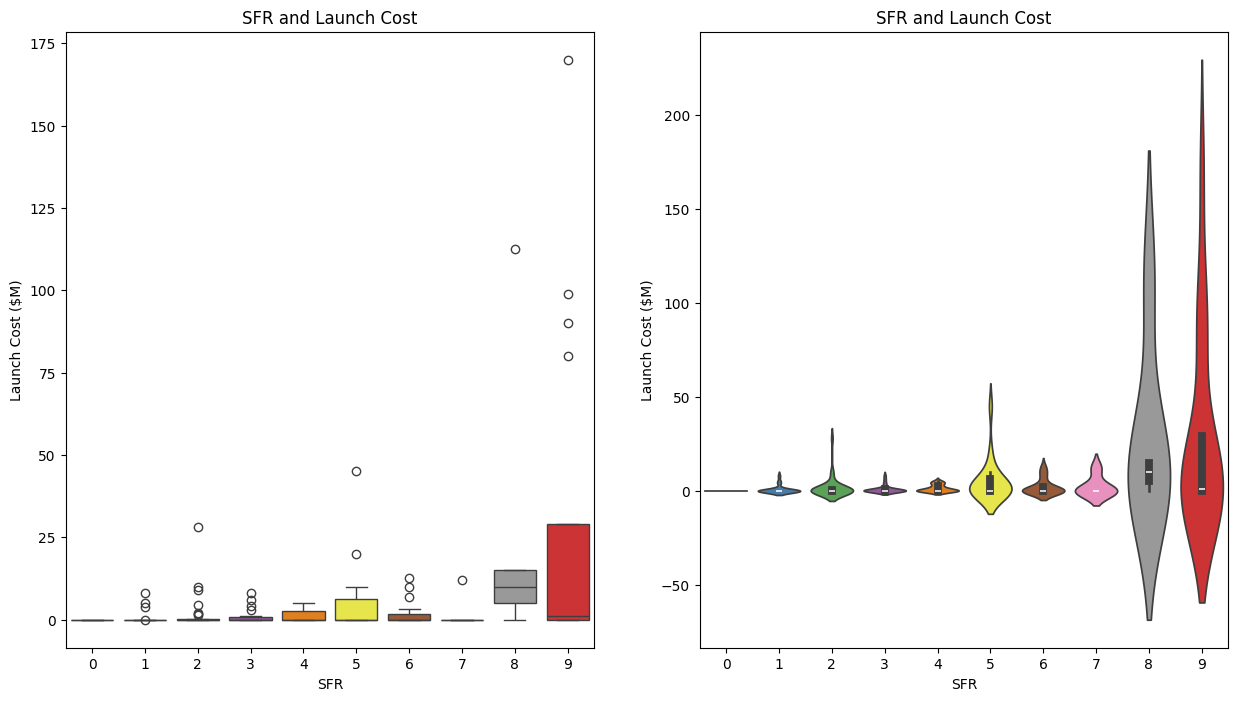

In [37]:
fig, ax = plt.subplots(1,2,figsize=(15, 8))
sns.boxplot(x='SFR', y='Launch Cost ($M)', data=df, ax=ax[0], hue='SFR', palette='Set1', dodge=False, legend=False).set_title('SFR and Launch Cost')
sns.violinplot(x='SFR', y='Launch Cost ($M)', data=df, ax=ax[1], hue='SFR', palette='Set1', dodge=False, legend=False).set_title('SFR and Launch Cost')

These graphs illustrate the relationship between mission cost and SFR. Both graphs show a trend of increasing SFR with higher launch costs, indicating that well-established companies can invest more resources into their missions. Companies with lower SFR are in early stages of development and have limited capability to allocate larger budgets to missions.

Additionally, the boxplot highlights the presence of outliers in the dataset. These outliers will be addressed in the second stage of data preprocessing.

## Data Preprocessing II

In [38]:
# dropping column country and company name because the SFR is dependent upon the mission specific parameters
df.drop(columns = ['Country', 'Company'], axis=1, inplace=True)

### Outlier removal

In [39]:
# Using Z score to remove outliers
cols = ['Payload (kg)', 'Launch Cost ($M)']
from scipy import stats
z = np.abs(stats.zscore(df[cols]))
df = df[(z < 3).all(axis=1)]

### Label Encoding the object type columns

In [40]:
from sklearn.preprocessing import LabelEncoder

#Label Encoding Object
le = LabelEncoder()

#object type columns
obj_cols = ['Launch Class', 'Orbit Altitude', 'Tech Type', 'Description']

#Label Encoding
for i in obj_cols:
    le.fit(df[i])
    df[i] = le.transform(df[i])
    print(i, df[i].unique(), '\n')

Launch Class [2 3 1 0] 

Orbit Altitude [1 3 0 2] 

Tech Type [2 1 0 3] 

Description [2 0 5 3 4 6 1] 



Converting SFR to binary column. All the SFR greater than equal to 6 are considered as 1 and less than 6 are considered as 0.

In [41]:
df['SFR'] = df['SFR'].apply(lambda x: 1 if x > 6 else 0)

## Coorelation Matrix Heatmap

<Axes: >

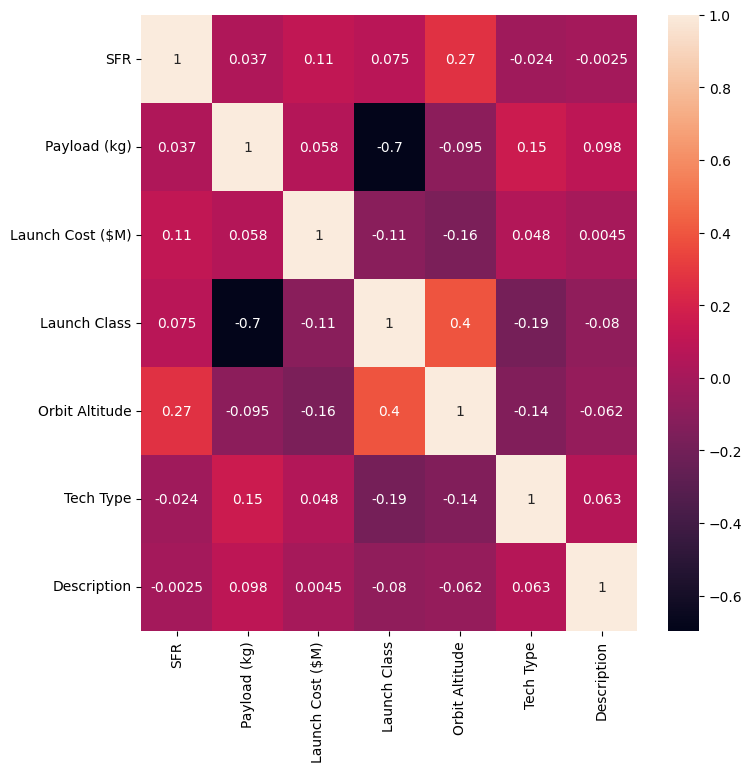

In [42]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True)

## Train Test Split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'SFR', axis=1), df['SFR'], test_size=0.3, random_state=0)

## Model Building

### Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier Object
rfc = RandomForestClassifier()

### Hyperparameter Tuning with GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV

# parameters for GridSearchCV
para_grid = {
    'min_samples_split': [2,4,6,8],
    'max_depth': [2,4,6,8],
    'min_samples_leaf': [2,4,6,8],
    'random_state': [0,42]
}

# GridSearchCV Object
grid = GridSearchCV(estimator=rfc, param_grid=para_grid, cv=5, verbose=2, n_jobs=-1)

#Fitting the model
grid.fit(X_train, y_train)

# Best parameters
print(grid.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}


In [47]:
# model with best parameters
rfc = RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=2, random_state=0)

# Fitting the model
rfc.fit(X_train, y_train)

# training accuracy
print('Training Accuracy: ', rfc.score(X_train, y_train))

# prediction
r_pred = rfc.predict(X_test)

Training Accuracy:  0.9098360655737705


### Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier Object
dtc = DecisionTreeClassifier()

### Hyperparameter Tuning with GridSearchCV

In [49]:
from sklearn.model_selection import GridSearchCV

# parameters for GridSearchCV
para_grid = {
    'min_samples_split': [2,4,6,8],
    'max_depth': [2,4,6,8],
    'min_samples_leaf': [2,4,6,8],
    'random_state': [0,42]
}

# GridSearchCV Object
grid = GridSearchCV(estimator=dtc, param_grid=para_grid, cv=5, verbose=2, n_jobs=-1)

# Fitting the model
grid.fit(X_train, y_train)

# Best parameters
print(grid.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'random_state': 42}


In [50]:
# model with best parameters
dtc = DecisionTreeClassifier(max_depth=2, min_samples_leaf=6, min_samples_split=2, random_state=0)

# Fitting the model
dtc.fit(X_train, y_train)

# training accuracy
print('Training Accuracy: ', dtc.score(X_train, y_train))

# prediction
d_pred = dtc.predict(X_test)

Training Accuracy:  0.8934426229508197


## Model Evaluation
Confusion Matrix

Text(0.5, 1.0, 'Decision Tree Classifier')

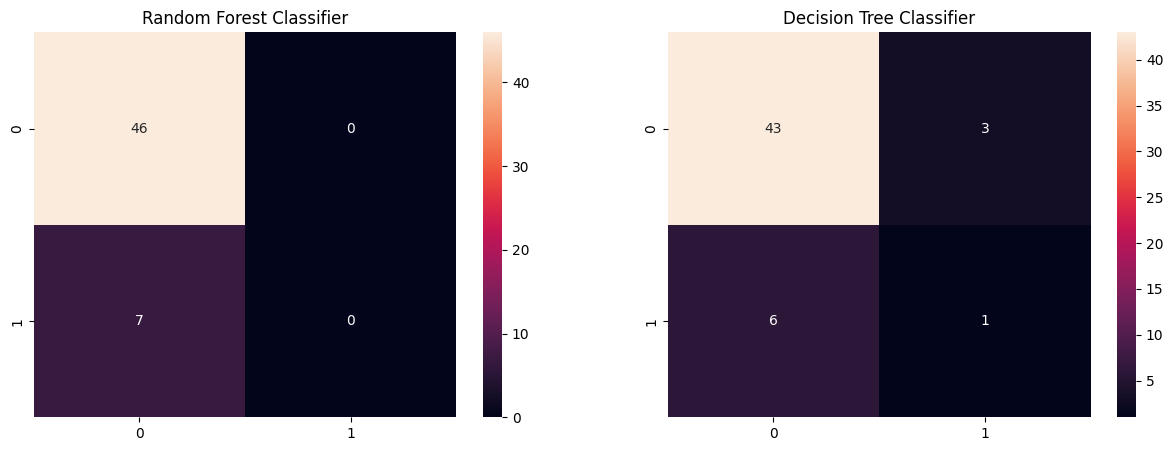

In [51]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1,2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_test, r_pred), annot=True, ax=ax[0], fmt='g').set_title('Random Forest Classifier')
sns.heatmap(confusion_matrix(y_test, d_pred), annot=True, ax=ax[1], fmt='g').set_title('Decision Tree Classifier')

/tmp/ipython-input-2519612094.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, ax=ax[0], color = 'r').set_title('Random Forest Classifier')
/tmp/ipython-input-2519612094.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r_pred, ax=ax[0], color = 'b')
/usr/local/lib/python3.12/dist-p

<Axes: title={'center': 'Decision Tree Classifier'}, xlabel='SFR', ylabel='Density'>

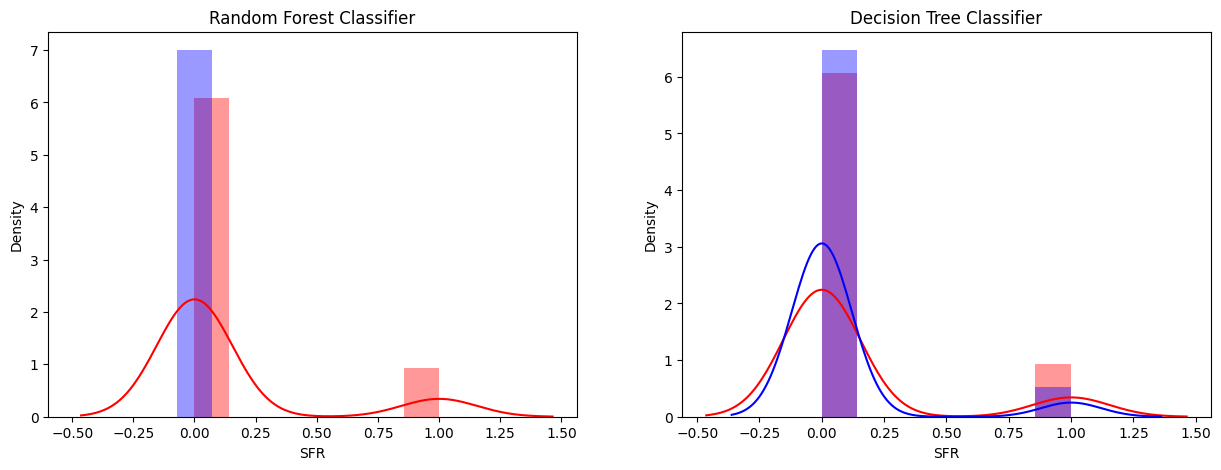

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
sns.distplot(y_test, ax=ax[0], color = 'r').set_title('Random Forest Classifier')
sns.distplot(r_pred, ax=ax[0], color = 'b')
sns.distplot(y_test, ax=ax[1], color = 'r').set_title('Decision Tree Classifier')
sns.distplot(d_pred, ax=ax[1], color = 'b')

## Classification Report

In [53]:
from sklearn.metrics import classification_report

print('Random Forest Classifier\n', classification_report(y_test, r_pred),'\n')
print('Decision Tree Classifier\n', classification_report(y_test, d_pred))

Random Forest Classifier
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        46
           1       0.00      0.00      0.00         7

    accuracy                           0.87        53
   macro avg       0.43      0.50      0.46        53
weighted avg       0.75      0.87      0.81        53
 

Decision Tree Classifier
               precision    recall  f1-score   support

           0       0.88      0.93      0.91        46
           1       0.25      0.14      0.18         7

    accuracy                           0.83        53
   macro avg       0.56      0.54      0.54        53
weighted avg       0.79      0.83      0.81        53



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



### Conclusion
---
The exploratory data analysis reveals that most companies in the dataset are based in the **United States**, resulting in a higher number of companies with strong SFR in the US. **China**, while having fewer companies than the United Kingdom, ranks second in the number of companies with SFR above 6. Most missions are **rocket-type**, **small launch class**, and **Low Earth Orbit (LEO)**, consistent with SFR distributions where most missions are rated 2-3, indicating early-stage development for many companies.


A clear relationship exists between **launch cost**, **payload**, and SFR. Missions with higher costs and larger payloads correspond to higher SFR, reflecting the capacity of well-established companies to carry heavier payloads and allocate more resources to their missions. Companies with lower SFR generally lack these capabilities and remain in the initial stages of development.


For predictive modeling, **Random Forest Classifier** and **Decision Tree Classifier** were implemented to predict SFR categories. The Random Forest achieved **training accuracy of 91%** and **test accuracy of 87%**, while the Decision Tree achieved **training accuracy of 89%** and **test accuracy of 83%**. The Random Forest model had perfect recall (1.00) for the majority class (SFR ≤ 6) but failed to predict the minority class (SFR > 6). The Decision Tree showed slightly better recall (0.14) for the minority class but overall lower performance. These results indicate that both models perform well for the majority of companies but struggle to identify high-SFR companies due to the small and imbalanced dataset. Expanding the dataset could improve minority-class prediction and overall model reliability.

Overall, the analysis demonstrates that most companies are in early development, and predictive modeling shows promise for majority-class predictions, while further data collection is required to reliably identify well-established companies with high SFR.